<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->


# Module - Neural network training and inference

Training a neural network involves quite a few steps. One need to specify how
to feed input training data, initialize model parameters, perform forward and
backward passes through the network, update weights based on computed gradients, do
model checkpoints, etc. During prediction, one ends up repeating most of these
steps. All this can be quite daunting to both newcomers as well as experienced
developers.

Luckily, MXNet modularizes commonly used code for training and inference in
the `module` (`mod` for short) package. `Module` provides both high-level and
intermediate-level interfaces for executing predefined networks. One can use
both interfaces interchangeably. We will show the usage of both interfaces in
this tutorial.

## Prerequisites

To complete this tutorial, we need:

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/install/index.html).  

- [Jupyter Notebook](http://jupyter.org/index.html) and [Python Requests](http://docs.python-requests.org/en/master/) packages.
```
pip install jupyter requests
```

## Preliminary

In this tutorial we will demonstrate `module` usage by training a
[Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP)
on the [UCI letter recognition](https://archive.ics.uci.edu/ml/datasets/letter+recognition)
dataset.

The following code downloads the dataset and creates an 80:20 train:test
split. It also initializes a training data iterator to return a batch of 32
training examples each time. A separate iterator is also created for test data.

In [1]:
import logging
import random
logging.getLogger().setLevel(logging.INFO)

import mxnet as mx
import numpy as np

mx.random.seed(1234)
np.random.seed(1234)
random.seed(1234)

fname = mx.test_utils.download('https://s3.us-east-2.amazonaws.com/mxnet-public/letter_recognition/letter-recognition.data')
data = np.genfromtxt(fname, delimiter=',')[:,1:]
label = np.array([ord(l.split(',')[0])-ord('A') for l in open(fname, 'r')])

batch_size = 32
ntrain = int(data.shape[0]*0.8)
train_iter = mx.io.NDArrayIter(data[:ntrain, :], label[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data[ntrain:, :], label[ntrain:], batch_size)

INFO:root:downloaded https://s3.us-east-2.amazonaws.com/mxnet-public/letter_recognition/letter-recognition.data into letter-recognition.data successfully


Next, we define the network.

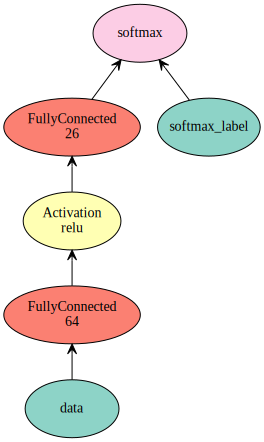

In [9]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)
net = mx.sym.Activation(net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=26)
net = mx.sym.SoftmaxOutput(net, name='softmax')
mx.viz.plot_network(net, node_attrs={"shape":"oval","fixedsize":"false"})

![svg](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/basic/module/output_3_0.svg?sanitize=true)



## Creating a Module

Now we are ready to introduce module. The commonly used module class is
`Module`. We can construct a module by specifying the following parameters:

- `symbol`: the network definition
- `context`: the device (or a list of devices) to use for execution
- `data_names` : the list of input data variable names
- `label_names` : the list of input label variable names

For `net`, we have only one data named `data`, and one label named `softmax_label`,
which is automatically named for us following the name `softmax` we specified for the `SoftmaxOutput` operator.

In [13]:
mod = mx.mod.Module(symbol=net,
                    context=mx.cpu(),
                    data_names=['data'],
                   label_names=['softmax_label'])

## Intermediate-level Interface

We have created module. Now let us see how to run training and inference using module's intermediate-level APIs. These APIs give developers flexibility to do step-by-step
computation by running `forward` and `backward` passes. It's also useful for debugging.

To train a module, we need to perform following steps:

- `bind` : Prepares environment for the computation by allocating memory.
- `init_params` : Assigns and initializes parameters.
- `init_optimizer` : Initializes optimizers. Defaults to `sgd`.
- `metric.create` : Creates evaluation metric from input metric name.
- `forward` : Forward computation.
- `update_metric` : Evaluates and accumulates evaluation metric on outputs of the last forward computation.
- `backward` : Backward computation.
- `update` : Updates parameters according to the installed optimizer and the gradients computed in the previous forward-backward batch.

This can be used as follows:

In [18]:
# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=.1))
# use SGD with learning rate 0.1 to train
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 0.1), ))
# use accuracy as the metric
metric = mx.metric.create('acc')
# train 5 epochs, i.e. going over the data iter one pass
for epoch in range(5):
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    print('Epoch %d, Training %s' % (epoch, metric.get()))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.


Epoch 0, Training ('accuracy', 0.765125)
Epoch 1, Training ('accuracy', 0.7825)
Epoch 2, Training ('accuracy', 0.7893125)
Epoch 3, Training ('accuracy', 0.7938125)
Epoch 4, Training ('accuracy', 0.8045)


In [49]:
##自己练习

#绑定用户 给定输入的 shape
mod.bind(data_shapes=train_iter.provide_data,label_shapes=train_iter.provide_label) 
#分配 并且 初始化 使用的参数
# mod.init_params(initializer=mx.init.Uniform(scale=0.1),force_init=True)
mod.init_params(initializer=mx.init.Xavier(),force_init=True)
mod.init_optimizer(optimizer='adam',optimizer_params=(('learning_rate', 0.01),),force_init=True)
acc=mx.metric.create('acc')

train_iter.reset()
for e in range(5):
    #不要忘记数据源的 reset
    train_iter.reset()
    acc.reset()
    for batch in train_iter:
        mod.forward(batch,True)
        mod.update_metric(acc,batch.label)
        mod.backward()
        mod.update()
    print(acc.get())

('accuracy', 0.6046875)
('accuracy', 0.730625)
('accuracy', 0.754875)
('accuracy', 0.7768125)
('accuracy', 0.7893125)


Expected output:


```
Epoch 0, Training ('accuracy', 0.434625)
Epoch 1, Training ('accuracy', 0.6516875)
Epoch 2, Training ('accuracy', 0.6968125)
Epoch 3, Training ('accuracy', 0.7273125)
Epoch 4, Training ('accuracy', 0.7575625)
```


To learn more about these APIs, visit [Module API](http://mxnet.io/api/python/module/module.html).

## High-level Interface

### Train

Module also provides high-level APIs for training, predicting and evaluating for
user convenience. Instead of doing all the steps mentioned in the above section,
one can simply call [fit API](http://mxnet.io/api/python/module/module.html#mxnet.module.BaseModule.fit)
and it internally executes the same steps.

To fit a module, call the `fit` function as follows:

In [68]:
# reset train_iter to the beginning
train_iter.reset()

# create a module
mod = mx.mod.Module(symbol=net,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])

# fit the module
mod.fit(train_iter,
        eval_data=val_iter,
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1},
        eval_metric='acc',
        num_epoch=7)

INFO:root:Epoch[0] Train-accuracy=0.371437
INFO:root:Epoch[0] Time cost=0.446
INFO:root:Epoch[0] Validation-accuracy=0.568500
INFO:root:Epoch[1] Train-accuracy=0.638312
INFO:root:Epoch[1] Time cost=0.430
INFO:root:Epoch[1] Validation-accuracy=0.644250
INFO:root:Epoch[2] Train-accuracy=0.703313
INFO:root:Epoch[2] Time cost=0.426
INFO:root:Epoch[2] Validation-accuracy=0.718250
INFO:root:Epoch[3] Train-accuracy=0.743313
INFO:root:Epoch[3] Time cost=0.452
INFO:root:Epoch[3] Validation-accuracy=0.724000
INFO:root:Epoch[4] Train-accuracy=0.769312
INFO:root:Epoch[4] Time cost=0.439
INFO:root:Epoch[4] Validation-accuracy=0.762500
INFO:root:Epoch[5] Train-accuracy=0.784937
INFO:root:Epoch[5] Time cost=0.482
INFO:root:Epoch[5] Validation-accuracy=0.730750
INFO:root:Epoch[6] Train-accuracy=0.800000
INFO:root:Epoch[6] Time cost=0.565
INFO:root:Epoch[6] Validation-accuracy=0.772750


Expected output:


```
INFO:root:Epoch[0] Train-accuracy=0.325437
INFO:root:Epoch[0] Time cost=0.550
INFO:root:Epoch[0] Validation-accuracy=0.568500
INFO:root:Epoch[1] Train-accuracy=0.622188
INFO:root:Epoch[1] Time cost=0.552
INFO:root:Epoch[1] Validation-accuracy=0.656500
INFO:root:Epoch[2] Train-accuracy=0.694375
INFO:root:Epoch[2] Time cost=0.566
INFO:root:Epoch[2] Validation-accuracy=0.703500
INFO:root:Epoch[3] Train-accuracy=0.732187
INFO:root:Epoch[3] Time cost=0.562
INFO:root:Epoch[3] Validation-accuracy=0.748750
INFO:root:Epoch[4] Train-accuracy=0.755375
INFO:root:Epoch[4] Time cost=0.484
INFO:root:Epoch[4] Validation-accuracy=0.761500
INFO:root:Epoch[5] Train-accuracy=0.773188
INFO:root:Epoch[5] Time cost=0.383
INFO:root:Epoch[5] Validation-accuracy=0.715000
INFO:root:Epoch[6] Train-accuracy=0.794687
INFO:root:Epoch[6] Time cost=0.378
INFO:root:Epoch[6] Validation-accuracy=0.802250
```

By default, `fit` function has `eval_metric` set to `accuracy`, `optimizer` to `sgd`
and optimizer_params to `(('learning_rate', 0.01),)`.

### Predict and Evaluate

To predict with module, we can call `predict()`. It will collect and
return all the prediction results.

In [69]:
y = mod.predict(val_iter)
assert y.shape == (4000, 26)

If we do not need the prediction outputs, but just need to evaluate on a test
set, we can call the `score()` function. It runs prediction in the input validation
dataset and evaluates the performance according to the given input metric.

It can be used as follows:

In [70]:
score = mod.score(val_iter, ['acc'])
print("Accuracy score is %f" % (score[0][1]))
assert score[0][1] > 0.76, "Achieved accuracy (%f) is less than expected (0.76)" % score[0][1]

Accuracy score is 0.772750


Expected output:


```
Accuracy score is 0.802250
```

Some of the other metrics which can be used are `top_k_acc`(top-k-accuracy),
`F1`, `RMSE`, `MSE`, `MAE`, `ce`(CrossEntropy). To learn more about the metrics,
visit [Evaluation metric](http://mxnet.io/api/python/metric/metric.html).

One can vary number of epochs, learning_rate, optimizer parameters to change the score
and tune these parameters to get best score.

### Save and Load

We can save the module parameters after each training epoch by using a checkpoint callback.

In [107]:
# construct a callback function to save checkpoints
model_prefix = 'models/mx_mlp'
checkpoint = mx.callback.do_checkpoint(model_prefix)

mod = mx.mod.Module(symbol=net)
train_iter.reset()
mod.fit(train_iter,val_iter,
        num_epoch=10, 
        epoch_end_callback=checkpoint,
        optimizer='adam',
        optimizer_params={'learning_rate':1e-3})

INFO:root:Epoch[0] Train-accuracy=0.370500
INFO:root:Epoch[0] Time cost=0.611
INFO:root:Saved checkpoint to "models/mx_mlp-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.530000
INFO:root:Epoch[1] Train-accuracy=0.600000
INFO:root:Epoch[1] Time cost=0.620
INFO:root:Saved checkpoint to "models/mx_mlp-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.625000
INFO:root:Epoch[2] Train-accuracy=0.661188
INFO:root:Epoch[2] Time cost=0.544
INFO:root:Saved checkpoint to "models/mx_mlp-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.668000
INFO:root:Epoch[3] Train-accuracy=0.700125
INFO:root:Epoch[3] Time cost=0.612
INFO:root:Saved checkpoint to "models/mx_mlp-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.696750
INFO:root:Epoch[4] Train-accuracy=0.724063
INFO:root:Epoch[4] Time cost=0.901
INFO:root:Saved checkpoint to "models/mx_mlp-0005.params"
INFO:root:Epoch[4] Validation-accuracy=0.723000
INFO:root:Epoch[5] Train-accuracy=0.742875
INFO:root:Epoch[5] Time cost=0.615
IN

Expected output:


```
INFO:root:Epoch[0] Train-accuracy=0.098437
INFO:root:Epoch[0] Time cost=0.421
INFO:root:Saved checkpoint to "mx_mlp-0001.params"
INFO:root:Epoch[1] Train-accuracy=0.257437
INFO:root:Epoch[1] Time cost=0.520
INFO:root:Saved checkpoint to "mx_mlp-0002.params"
INFO:root:Epoch[2] Train-accuracy=0.457250
INFO:root:Epoch[2] Time cost=0.562
INFO:root:Saved checkpoint to "mx_mlp-0003.params"
INFO:root:Epoch[3] Train-accuracy=0.558187
INFO:root:Epoch[3] Time cost=0.434
INFO:root:Saved checkpoint to "mx_mlp-0004.params"
INFO:root:Epoch[4] Train-accuracy=0.617750
INFO:root:Epoch[4] Time cost=0.414
INFO:root:Saved checkpoint to "mx_mlp-0005.params"
```

To load the saved module parameters, call the `load_checkpoint` function. It
loads the Symbol and the associated parameters. We can then set the loaded
parameters into the module.

In [108]:
# mod=mx.mod.Module(net)
# mod.bind(train_iter.provide_data,train_iter.provide_label)
# mod.init_params()
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 10)
# assert sym.tojson() == net.tojson()

# assign the loaded parameters to the module
mod.set_params(arg_params, aux_params)

In [109]:
mod.score(train_iter,['acc'])

[('accuracy', 0.7844375)]

Or if we just want to resume training from a saved checkpoint, instead of
calling `set_params()`, we can directly call `fit()`, passing the loaded
parameters, so that `fit()` knows to start from those parameters instead of
initializing randomly from scratch. We also set the `begin_epoch` parameter so that
`fit()` knows we are resuming from a previously saved epoch.

In [111]:
mod = mx.mod.Module(symbol=sym)
train_iter.reset()
mod.fit(train_iter,
        num_epoch=21,
        arg_params=arg_params,
        aux_params=aux_params,
        begin_epoch=3)
assert score[0][1] > 0.77, "Achieved accuracy (%f) is less than expected (0.77)" % score[0][1]        

INFO:root:Epoch[3] Train-accuracy=0.779813
INFO:root:Epoch[3] Time cost=0.460
INFO:root:Epoch[4] Train-accuracy=0.782937
INFO:root:Epoch[4] Time cost=0.431
INFO:root:Epoch[5] Train-accuracy=0.788687
INFO:root:Epoch[5] Time cost=0.445
INFO:root:Epoch[6] Train-accuracy=0.790000
INFO:root:Epoch[6] Time cost=0.464
INFO:root:Epoch[7] Train-accuracy=0.793188
INFO:root:Epoch[7] Time cost=0.496
INFO:root:Epoch[8] Train-accuracy=0.794750
INFO:root:Epoch[8] Time cost=0.467
INFO:root:Epoch[9] Train-accuracy=0.797875
INFO:root:Epoch[9] Time cost=0.475
INFO:root:Epoch[10] Train-accuracy=0.801312
INFO:root:Epoch[10] Time cost=0.590
INFO:root:Epoch[11] Train-accuracy=0.804750
INFO:root:Epoch[11] Time cost=0.475
INFO:root:Epoch[12] Train-accuracy=0.806187
INFO:root:Epoch[12] Time cost=0.568
INFO:root:Epoch[13] Train-accuracy=0.808187
INFO:root:Epoch[13] Time cost=0.469
INFO:root:Epoch[14] Train-accuracy=0.810875
INFO:root:Epoch[14] Time cost=0.476
INFO:root:Epoch[15] Train-accuracy=0.814375
INFO:root:



Expected output:


```
INFO:root:Epoch[3] Train-accuracy=0.555438
INFO:root:Epoch[3] Time cost=0.377
INFO:root:Epoch[4] Train-accuracy=0.616625
INFO:root:Epoch[4] Time cost=0.457
INFO:root:Epoch[5] Train-accuracy=0.658438
INFO:root:Epoch[5] Time cost=0.518
...........................................
INFO:root:Epoch[18] Train-accuracy=0.788687
INFO:root:Epoch[18] Time cost=0.532
INFO:root:Epoch[19] Train-accuracy=0.789562
INFO:root:Epoch[19] Time cost=0.531
INFO:root:Epoch[20] Train-accuracy=0.796250
INFO:root:Epoch[20] Time cost=0.531
```



<!-- INSERT SOURCE DOWNLOAD BUTTONS -->



### 如何使用一个 预训练的模型？

In [180]:
pretrained='models/mx_mlp'
_sym,_ags,_aux=mx.model.load_checkpoint(pretrained,10)
_mode=mx.mod.Module(_sym,data_names=['data'],label_names=['softmax_label']) #查看 _sym.list_arguments(),给出输入输出名
N=32
_mode.bind(data_shapes=[('data',(N,16))],label_shapes=[('softmax_label',(N,))])
_mode.set_params(_ags,_aux)
_mode.score(val_iter,['acc'])
# _mod.predict(mx.nd.random.uniform(-1,1,shape=(N,16))).shape

[('accuracy', 0.779)]

In [232]:
pretrained='models/mx_mlp'
_sym,_ags,_aux=mx.model.load_checkpoint(pretrained,10)
#_sym.list_inputs(),_sym.list_outputs很有用，可以分析哪些是output
_sym=_sym['softmax_output'] 
_mode=mx.mod.Module(_sym,data_names=['data'],label_names=None) #查看 _sym.list_arguments(),给出输入输出名
N=32
_mode.bind(data_shapes=[('data',(N,16))],label_shapes=None)
_mode.set_params(_ags,_aux,allow_missing=True)
# _mode.score(val_iter,['acc'])
# _mod.predict(mx.nd.random.uniform(-1,1,shape=(N,16)))

### 如何从 预训练的模型 恢复训练？

In [151]:
pretrained='models/mx_mlp'
_sym,_args,_aux=mx.model.load_checkpoint(pretrained,10)
_mod=mx.mod.Module(_sym)
_mod.fit(train_iter,val_iter,arg_params=_args,aux_params=_aux,num_epoch=15,begin_epoch=10)

INFO:root:Epoch[10] Train-accuracy=0.778687
INFO:root:Epoch[10] Time cost=0.423
INFO:root:Epoch[10] Validation-accuracy=0.776750
INFO:root:Epoch[11] Train-accuracy=0.785000
INFO:root:Epoch[11] Time cost=0.552
INFO:root:Epoch[11] Validation-accuracy=0.765750
INFO:root:Epoch[12] Train-accuracy=0.787188
INFO:root:Epoch[12] Time cost=0.611
INFO:root:Epoch[12] Validation-accuracy=0.766250
INFO:root:Epoch[13] Train-accuracy=0.790063
INFO:root:Epoch[13] Time cost=0.517
INFO:root:Epoch[13] Validation-accuracy=0.768750
INFO:root:Epoch[14] Train-accuracy=0.792500
INFO:root:Epoch[14] Time cost=0.590
INFO:root:Epoch[14] Validation-accuracy=0.782750
